In [2]:
import os
import sys
sys.path.append('/home/kevinteng/Desktop/DE_Project')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from coord_conv import CoordConv
import cv2
import utils
import utils_vis
import utils_model
from sklearn.model_selection import train_test_split
from utils_vis import plot_comparison
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from random import randint, seed
from utils import stack4plot, similarity_multi, similarity_multiplication
from utils_vis import overlapMasks, overlapMasks02

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

In [87]:
one_hot_image = np.load("/home/kevinteng/Desktop/npy/fullSess04/sim_one_fullSess04/one_hot/one_last_DG13_3-8-17_preprocessed_dF_fullSess04.npy")
sim_scores = np.load("/home/kevinteng/Desktop/npy/fullSess04/sim_one_fullSess04/sim_last/sim_last_DG13_3-8-17_preprocessed_dF_fullSess04.npy")
session = np.load("/home/kevinteng/Desktop/jpg_to_npy_benchmark/DG13_3-8-17_preprocessed_dF.npy")

In [17]:
batch_list = []
for batch in range(len(one_hot_image)):
    coord_list = []
    for n in range(len(one_hot_image[0])):
        one_im = np.squeeze(one_hot_image[batch,n])
        coords = np.array(np.where(one_im==np.max(one_im)))
        coords = coords.reshape((2))
        coord_list.append(coords)
    batch_list.append(np.array(coord_list))

In [31]:
one_hot_coords = np.array(batch_list)/99 #normalize

In [51]:
one_hot_coords.shape

(94, 100, 2)

In [60]:
sim_scores.shape

(752, 100)

In [58]:
#index where there are coordinates at the border for first one_hot_coords
inps_coords = one_hot_coords[0]
idx_boarder = np.array(np.where((inps_coords==1.0) ^ (inps_coords==0.0))).T

In [59]:
print("Shape: ",idx_boarder.shape)
print(idx_boarder)

Shape:  (40, 2)
[[ 1  0]
 [ 7  1]
 [ 9  1]
 [12  0]
 [12  1]
 [14  0]
 [21  0]
 [21  1]
 [23  0]
 [23  1]
 [26  0]
 [31  0]
 [33  1]
 [35  0]
 [35  1]
 [36  0]
 [39  0]
 [41  1]
 [48  0]
 [48  1]
 [49  0]
 [52  0]
 [52  1]
 [53  0]
 [59  0]
 [59  1]
 [60  0]
 [60  1]
 [61  1]
 [62  0]
 [62  1]
 [68  0]
 [71  0]
 [71  1]
 [74  0]
 [74  1]
 [78  0]
 [78  1]
 [81  0]
 [82  0]]


In [82]:
#compute latent space
latent_space = tf.convert_to_tensor(np.concatenate((inps_coords, sim_scores[0][:,np.newaxis]), axis=-1)) 
latent_space = latent_space[tf.newaxis,:,:,tf.newaxis]
latent_space = tf.cast(latent_space, tf.float32)

In [83]:
latent_space.shape

TensorShape([1, 100, 3, 1])

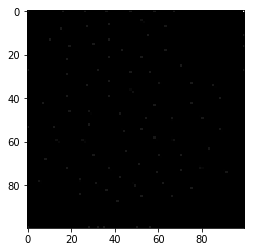

In [70]:
one_hot_im = np.sum(np.squeeze(one_hot_image[0]), axis = 0)
plt.imshow(one_hot_im, cmap = 'gray')

In [73]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras.layers import Input, Softmax, Dropout
from tensorflow.keras.regularizers import l1
from utils_model import conv_block, coordconv_block, up_block, up_coord_block
from tensorflow.keras import layers    

def decoder(latent_dim):
    flat_01 = Flatten()(latent_dim)
    dense_01 = Dense(25*25*32, activation = 'relu')(flat_01)
    dense_01 = Reshape((25,25,32))(dense_01)
    up_01 = up_coord_block(dense_01, up_size = 2, x_dim = 50, y_dim = 50, filters = 64, 
                           kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')
    up_02 = up_block(up_01, up_size = 2, filters = 32, kernel_size = 3,
                            strides = 1, padding = 'same', activation = 'relu')
    output = Conv2D(filters = 1, kernel_size = 3, strides = 1,
                    padding = 'same', activation = None)(up_02)
    return output

In [76]:
n_neurons = 100
#decoder
latent_dim = Input(shape=(n_neurons, 3, 1))
decoder_model = Model(latent_dim, decoder(latent_dim))
decoder_model.load_weights("model_weights/decoder_model_{}.h5".format('fullSess04'))

In [84]:
reconstuction = decoder_model(latent_space)

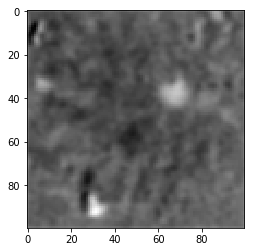

In [94]:
#input image
re_list = utils.resize(session, 100)
re_list = utils.min_max_norm(re_list)

plt.imshow(tf.squeeze(re_list[0]), cmap = 'gray')

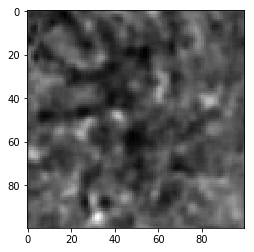

In [86]:
plt.imshow(tf.squeeze(reconstuction), cmap = 'gray')